In [2]:
import pandas as pd
import numpy as np
from numpy.fft import fft, ifft, fft2, ifft2, fftshift
from scipy import signal
import os
import sys

## Load measurement data

In [10]:
def readBonsai(path):
    bonsai = pd.read_csv(path)
    bonsai = bonsai[['accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ']]
    return bonsai
    
def readEXLS3(path):
    exl = pd.read_fwf(path)
    exl.columns = exl.iloc[2]
    exl = exl[['a_x [g]:', 'a_y [g]:', 'a_z [g]:', 'ar_x [rad/s]:', 'ar_y [rad/s]:', 'ar_z [rad/s]:']]
    exl.rename(index=str, columns={
        'a_x [g]:': 'accX', 'a_y [g]:': 'accY', 'a_z [g]:': 'accZ', 
        'ar_x [rad/s]:': 'gyrX', 'ar_y [rad/s]:': 'gyrY', 'ar_z [rad/s]:': 'gyrZ'
    }, inplace=True)
    exl = exl.iloc[3:]
    exl.reset_index(drop=True, inplace=True)
    exl = exl.apply(pd.to_numeric)
    exl = exl.multiply(9.80665)
    return exl

def tagColumnNames(df, tag):
    newColumnNames = {columnName: columnName + tag for columnName in df.columns}
    return df.rename(index=int, columns=newColumnNames)


fileNameLocationMap = {
    'I-L9H': 'hip-r',
    'I-74V': 'hip-l',
    'I-WXB': 'knee-r',
    'I-0GN': 'knee-l',
    'Gait - R': 'foot-r',
    'Gait - L': 'foot-l'
}
def mapFileNameToLocation(fileName):
    for name, location in fileNameLocationMap.items():
        if (name in fileName):
            return location
    return 'unknown'

def loadMeasurements(path):
    measurements = {}
    for fileOrDir in os.listdir(path):
        if (fileOrDir.endswith('.txt')):
            measurement = readEXLS3(os.path.join(path, fileOrDir))
        elif (fileOrDir.endswith('.csv')):
            measurement = readBonsai(os.path.join(path, fileOrDir))
        if (measurement is not None):
            measurementLocation = mapFileNameToLocation(fileOrDir)
            measurement = tagColumnNames(measurement, '_' + measurementLocation)
            measurements[measurementLocation] = measurement
    return measurements
    
measurements = loadMeasurements(os.path.join('..', 'data', '24-06-19', 'martin 2'))

## Synchronize the sensor data

In [9]:
# code taken from https://lexfridman.com/fast-cross-correlation-and-time-series-synchronization-in-python/
def crossCorrelation(x, y):
    f1 = fft(x)
    f2 = fft(np.flipud(y))
    cc = np.real(ifft(f1 * f2))
    return fftshift(cc)
 
def computeShift(short, longB):
    lenDifference = len(longB) - len(short)
    longA = np.pad(short, (lenDifference, 0), 'constant', constant_values=-sys.maxsize - 1)
    c = crossCorrelation(longA, longB)
    zero_index = int(len(longA) / 2) - 1
    shift = zero_index - np.argmax(c)
    return shift

def alignSignals(dfX, dfY, startX, endX, startY, endY):
    windowDFX = dfX[startX:endX].abs()
    windowDFY = dfY[startY:endY].abs()
    windowDFX = [x if x > windowDFX.mean() else 0 for x in windowDFX]
    windowDFY = [y if y > windowDFY.mean() else 0 for y in windowDFY]
    isDFXShort = len(dfX) <= len(dfY)
    short, windowShort, shortStart = (dfX, windowDFX, startX) if isDFXShort else (dfY, windowDFY, startY)
    long, windowLong, longStart = (dfY, windowDFY, startY) if isDFXShort else (dfX, windowDFX, startX)
#     shortOffset = signal.correlate(windowLong, windowShort, mode='valid').argmax()
    shortOffset = np.argmax(windowLong) - np.argmax(windowShort)
    startOffset = shortStart - longStart
    offset = shortOffset - startOffset
    print(offset)
    short = short.shift(offset, axis='index')
    return (short, long) if isDFXShort else (long, short)

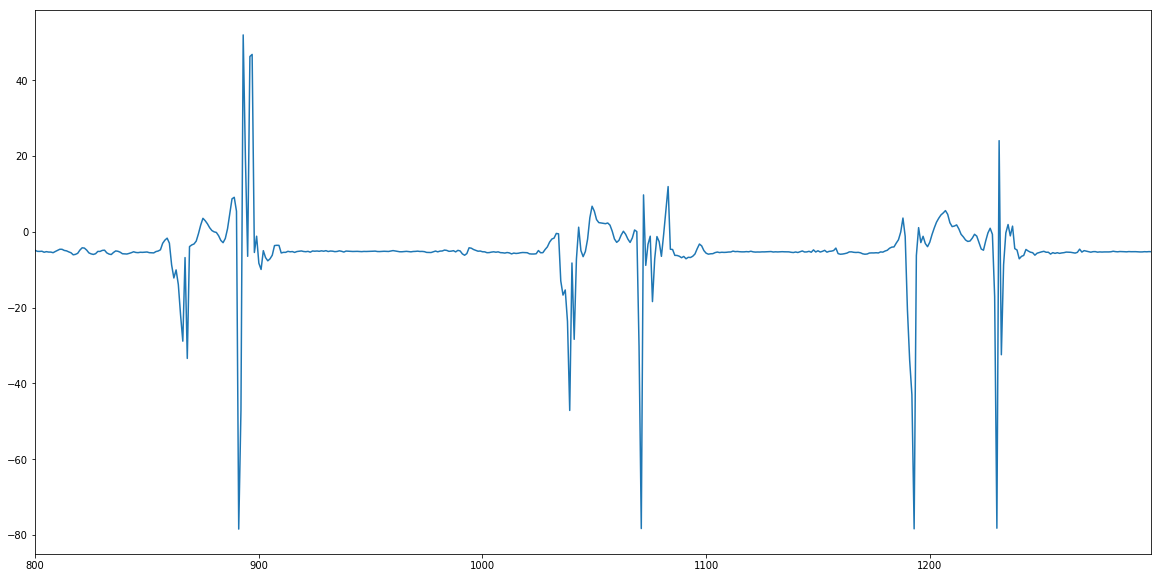

In [824]:
measurements['foot-r']['accY_foot-r'][800:1300].plot(figsize=(20, 10))

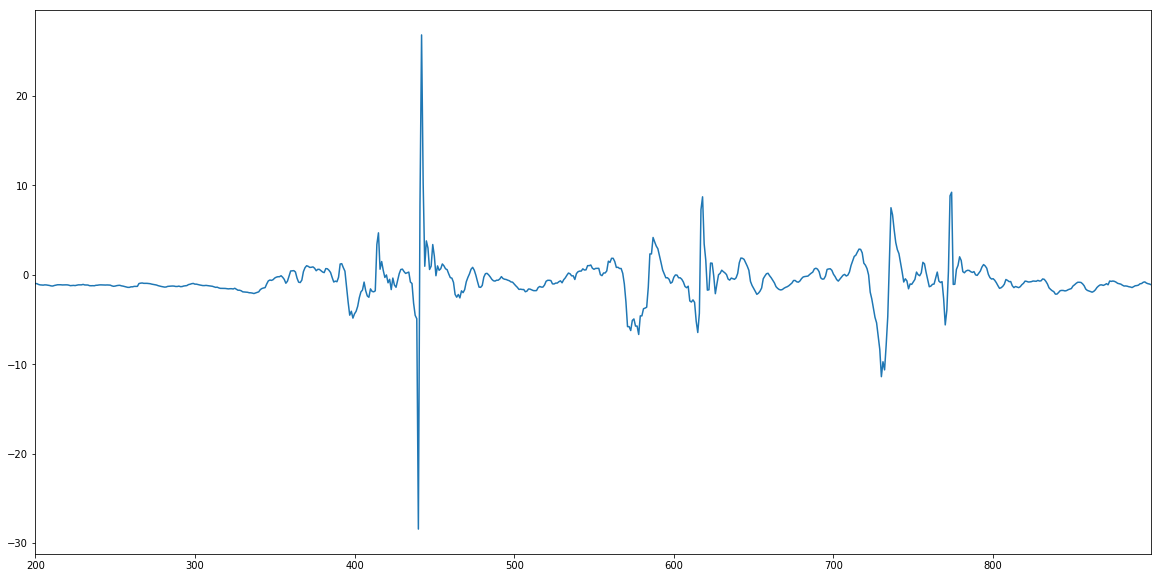

In [831]:
measurements['hip-r']['accY_hip-r'][200:900].plot(figsize=(20, 10))

In [11]:
# martin 1
# measurements['hip-r']['accY_hip-r'], measurements['foot-r']['accY_foot-r'] = alignSignals(measurements['hip-r']['accY_hip-r'], measurements['foot-r']['accY_foot-r'], 600, 1200, 950, 1600)

# martin 2
measurements['hip-r']['accY_hip-r'], measurements['foot-r']['accY_foot-r'] = alignSignals(measurements['hip-r']['accY_hip-r'], measurements['foot-r']['accY_foot-r'], 200, 900, 800, 1300)

451


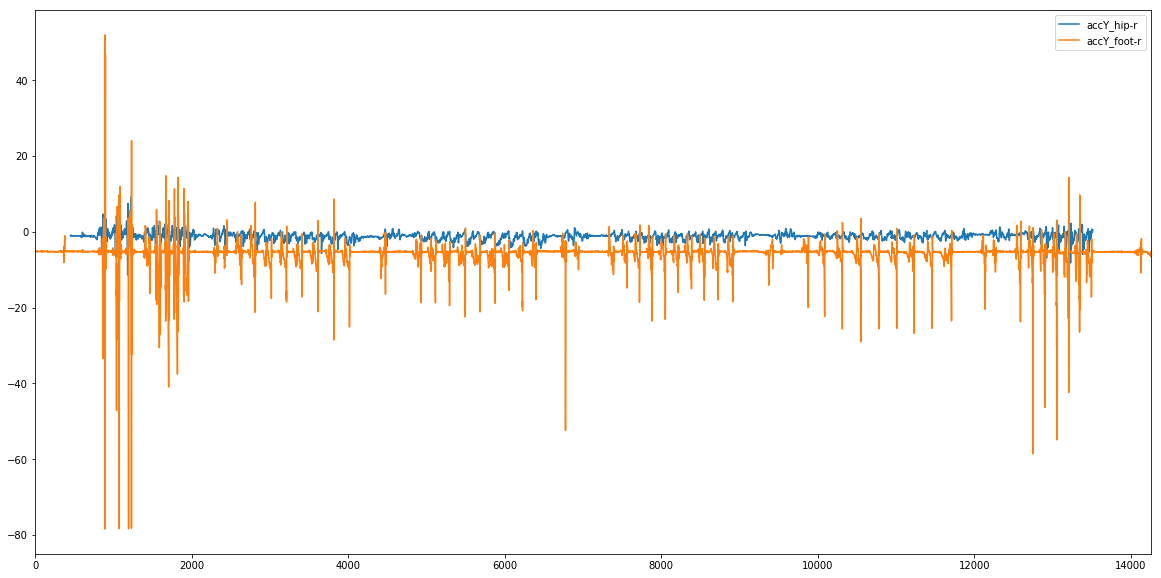

In [13]:
joined = measurements['hip-r'].join(measurements['foot-r'], how='outer')[['accY_hip-r', 'accY_foot-r']]
joined.plot(figsize=(20, 10))

In [725]:
# measurements['hip-r'] = measurements['hip-r'].shift(370, axis='index') # manually adjusted 370